In [1]:
# This file is used to generate the figure used in usage section of the cos
import sys
import os

sys.path.insert(0, os.path.abspath("../../.."))

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

# import the nmf models
from mcrnmf import MinVol, SNPA

# to import dataset shown in the examples shown below
from mcrnmf.datasets import load_rxn_spectra

In [2]:
# save path for plots
SAVE_PATH = os.path.abspath("../../source/_static/figures")

In [3]:
# import the time-series reaction dataset
X, wv, time = load_rxn_spectra()

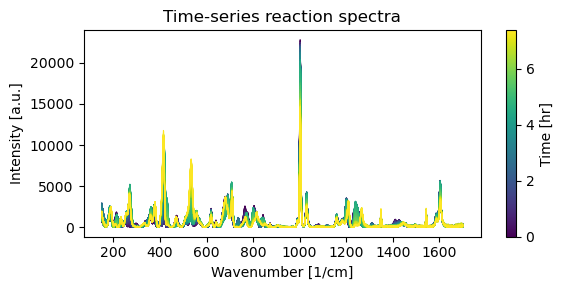

In [4]:
# visualization of the spectral data
norm = Normalize(vmin=time[0], vmax=time[-1])
fig, ax = plt.subplots(figsize=(6, 3))
for i in range(X.shape[1]):
    ax.plot(wv, X[:, i], color=plt.cm.viridis(norm(time[i])), linewidth=0.75)
ax.set_xlabel("Wavenumber [1/cm]")
ax.set_ylabel("Intensity [a.u.]")
cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm), ax=ax
)
cbar.set_label("Time [hr]")
ax.set_title("Time-series reaction spectra")
fig.tight_layout()
plt.show()

fig.savefig(os.path.join(SAVE_PATH, "time_series_spectra.svg"), dpi=600)

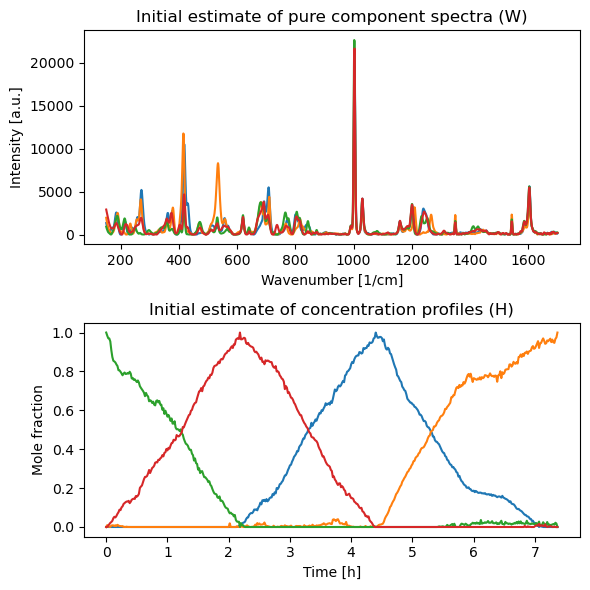

In [5]:
# generate an initial guess for W and H using SNPA
num_components = 4  # decompose into 4 components
snpa = SNPA(rank=num_components, iter_max=1000)
# fit the model to generate the guess W and H
snpa.fit(X=X)
Wi = snpa.W.copy()
Hi = snpa.H.copy()

# visualization of the generated guess
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
axs[0].plot(wv, Wi)
axs[0].set_xlabel("Wavenumber [1/cm]")
axs[0].set_ylabel("Intensity [a.u.]")
axs[0].set_title("Initial estimate of pure component spectra (W)")
axs[1].plot(time, Hi.T)
axs[1].set_xlabel("Time [h]")
axs[1].set_ylabel("Mole fraction")
axs[1].set_title("Initial estimate of concentration profiles (H)")
fig.tight_layout()
plt.show()

fig.savefig(os.path.join(SAVE_PATH, "initial_guess_from_SNPA.svg"), dpi=600)

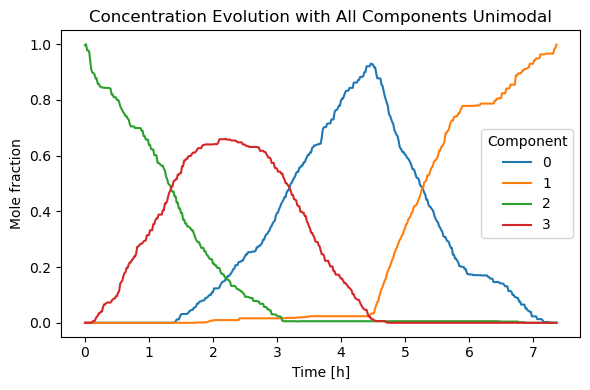

In [6]:
# Create a MinVol instance with constraints
mvol_uni_all = MinVol(
    rank=num_components,
    constraint_kind=1,  # Sum of concentrations at each timepoint ≤ 1
    unimodal={"H": True},  # All concentration profiles should be unimodal
    lambdaa=1e-4,  # Regularization parameter controlling the simplex volume
    iter_max=2000,  # Maximum number of iterations
)

# Fit the MinVol model using initial estimates from SNPA
mvol_uni_all.fit(X=X, Wi=Wi, Hi=Hi)

# Visualize the refined concentration profiles
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(time, mvol_uni_all.H.T)
ax.legend([f"{i}" for i in range(num_components)], title="Component")
ax.set_xlabel("Time [h]")
ax.set_ylabel("Mole fraction")
ax.set_title("Concentration Evolution with All Components Unimodal")
fig.tight_layout()
plt.show()

fig.savefig(os.path.join(SAVE_PATH, "conc_mvol_uni_all.svg"), dpi=600)

Did the algorithm converge? True


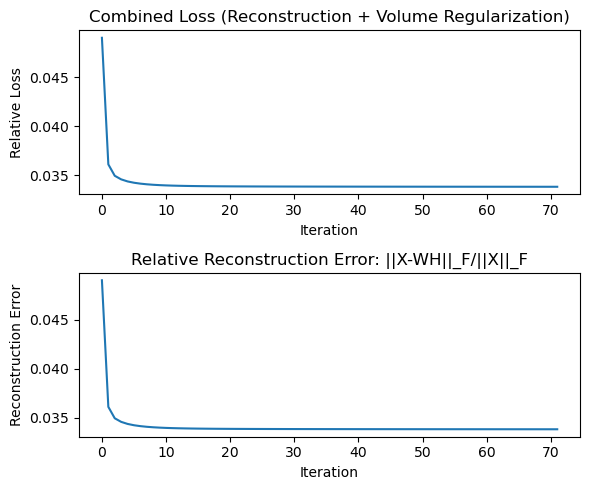

Final relative reconstruction error: 0.033805


In [7]:
# Check if the algorithm converged within the maximum iterations
converged = mvol_uni_all.is_converged
print(f"Did the algorithm converge? {converged}")

# Plot the relative loss over iterations
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 5))

# Plot the overall loss (includes both reconstruction error and volume regularization)
axs[0].plot(mvol_uni_all.rel_loss_ls)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Relative Loss")
axs[0].set_title("Combined Loss (Reconstruction + Volume Regularization)")

# Plot just the reconstruction error component
axs[1].plot(mvol_uni_all.rel_reconstruction_error_ls)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Reconstruction Error")
axs[1].set_title("Relative Reconstruction Error: ||X-WH||_F/||X||_F")

fig.tight_layout()
plt.show()

# Get the final reconstruction error
final_error = mvol_uni_all.rel_reconstruction_error_ls[-1]
print(f"Final relative reconstruction error: {final_error:.6f}")

fig.savefig(os.path.join(SAVE_PATH, "mvol_all_performance.svg"), dpi=600)

All columns sum to 1: True
Unimodality satisfied: 0/4 components


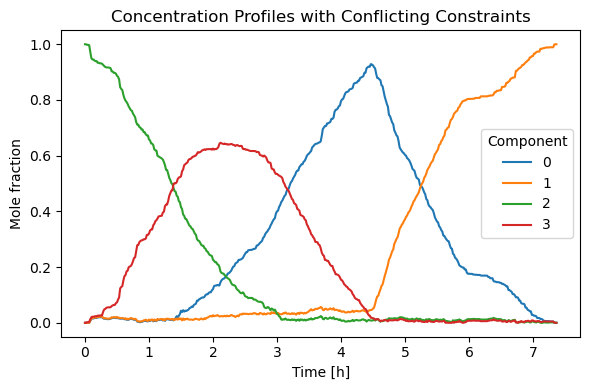

In [8]:
# Apply both column sum=1 constraint and unimodality
mvol_incompatible = MinVol(
    rank=num_components,
    constraint_kind=4,  # Sum of concentrations at each timepoint = 1
    unimodal={"H": True},  # All concentration profiles should be unimodal
    lambdaa=1e-4,
    iter_max=2000,
)

# Fit the model with potentially incompatible constraints
mvol_incompatible.fit(X=X, Wi=Wi, Hi=Hi)

# Visualize the results
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(time, mvol_incompatible.H.T)
ax.legend([f"{i}" for i in range(num_components)], title="Component")
ax.set_xlabel("Time [h]")
ax.set_ylabel("Mole fraction")
ax.set_title("Concentration Profiles with Conflicting Constraints")

# Check if columns sum to 1 exactly
column_sums = mvol_incompatible.H.sum(axis=0)
print(f"All columns sum to 1: {np.allclose(column_sums, 1.0)}")


def is_unimodal(arr_1d: np.ndarray):
    """Verifies that the array has at most one peak"""
    increasing = False
    decreasing = False
    for i in range(1, arr_1d.size):
        if arr_1d[i] > arr_1d[i - 1]:
            increasing = True
            if decreasing:
                return False
        elif arr_1d[i] < arr_1d[i - 1]:
            decreasing = True
    return True


unimodal_status = []
for i in range(mvol_incompatible.H.shape[0]):
    unimodal_status.append(is_unimodal(mvol_incompatible.H[i, :]))
print(
    f"Unimodality satisfied: {sum(unimodal_status)}/{len(unimodal_status)} components"
)
fig.tight_layout()
plt.show()

fig.savefig(os.path.join(SAVE_PATH, "constraints_conflict.svg"), dpi=600)

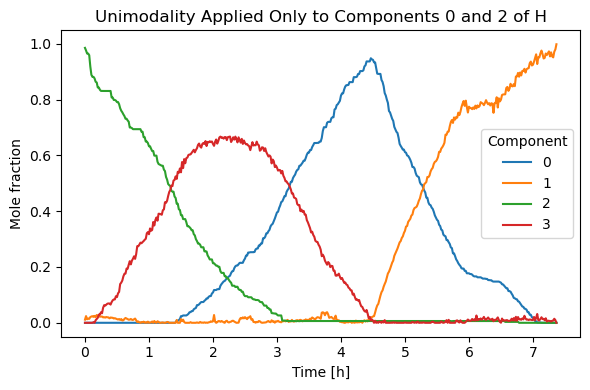

In [9]:
mvol_uni_some = MinVol(
    rank=num_components,
    constraint_kind=1,
    unimodal={"H": [True, False, True, False]},
    lambdaa=1e-4,
    iter_max=2000,
)

# Fit the model with selective constraints
mvol_uni_some.fit(X=X, Wi=Wi, Hi=Hi)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(time, mvol_uni_some.H.T)
ax.legend([f"{i}" for i in range(num_components)], title="Component")
ax.set_xlabel("Time [h]")
ax.set_ylabel("Mole fraction")
ax.set_title("Unimodality Applied Only to Components 0 and 2 of H")
fig.tight_layout()
plt.show()

fig.savefig(os.path.join(SAVE_PATH, "conc_mvol_uni_some.svg"), dpi=600)

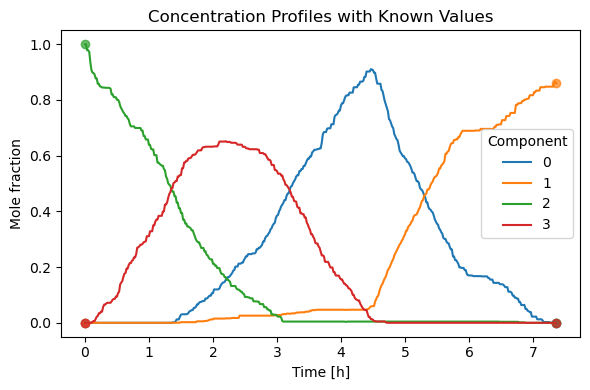

In [10]:
num_timepoints = time.size
known_H = np.full((num_components, num_timepoints), np.nan)

# suppose you know the concentrations at first time point
known_H[:, 0] = [0, 0, 1, 0]
# suppose you also know the concentrations at the last time point
known_H[:, -1] = [0, 0.86, 0, 0]

mvol_known = MinVol(
    rank=num_components,
    constraint_kind=1,
    unimodal={"H": True},
    lambdaa=1e-4,
    iter_max=2000,
)

# the known H value information is provided here
mvol_known.fit(X=X, Wi=Wi, Hi=Hi, known_H=known_H)

# visualize the results
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(time, mvol_known.H.T)
ax.legend([f"{i}" for i in range(num_components)], title="Component")

# add the known values
for i in range(num_components):
    known_indices = np.where(~np.isnan(known_H[i, :]))[0]
    ax.scatter(time[known_indices], known_H[i, known_indices], marker="o", alpha=0.7)
ax.set_xlabel("Time [h]")
ax.set_ylabel("Mole fraction")
ax.set_title("Concentration Profiles with Known Values")
fig.tight_layout()
plt.show()

fig.savefig(os.path.join(SAVE_PATH, "known_conc.svg"), dpi=600)